# 演習5 - VQE(変分量子固有値ソルバー)
***

## 歴史的背景


過去10年間で、量子コンピューターは急速に成熟し、量子的な手法で自然の法則をシミュレートできるコンピューティングシステムというファインマンの夢を実現し始めました。2014年の論文において、最初に、アルベルト・ペルッゾが **変分量子固有値ソルバー(VQE)** を発表しました。分子の基底状態エネルギー(最小エネルギー)をこれまでの手法より短い回路で見つけるアルゴリズムです。[1]　そして、2017年に、IBMの量子チームがVQEアルゴリズムを使って水素化リチウム分子の基底状態をシミュレートしました。[2]

VQEのマジックは、問題の計算ワークロードのうちの一部を古典コンピューターにアウトソースすることです。アルゴリズムは、まず試行状態(ansatz、ベストな推測)と呼ばれるパラメーター化された量子回路から始め、古典オプティマイザーを使ってこの回路の最適なパラメーターを探します。VQEが古典アルゴリズムより優っている点は、量子回路が問題の厳密な波動関数を表現し保存できるということです。これは古典コンピューターでは指数関数的に難しい問題です。

この演習５では、分子の基底状態と基底エネルギーを決定するために、変分量子固有値ソルバーを設定することで、ファインマンの夢をみなさんに実現してもらいます。この問題は、基底状態は、様々な分子の特性を計算するために使われるので興味深いことです。例えば、原子核における厳密な力は分子動力学シミュレーションで化学システムにおいて何が起こっているのか時間変化を伴って探究することができます。[3]


### 参考文献

1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." Nature communications 5.1 (2014): 1-7.
2. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246.
3. Sokolov, Igor O., et al. "Microcanonical and finite-temperature ab initio molecular dynamics simulations on quantum computers." Physical Review Research 3.1 (2021): 013125.


## はじめに

VQEの実装において、特に試行状態(ansatz)の量子回路に注目して、どのようにシミュレーションを実装するか、その方法を選びます。
ノイズのある量子コンピューターにおいてVQEを実行する際に重要な課題の一つは、忠実度(fidelity)をロスしないように、最もコンパクトな量子回路を基底状態として選ぶことです。この問題は、この課題に基づいて作られています。
この課題は、実際には、精度を損わずに、２量子ビットゲート（例：CNOT）の数と変分パラメーターの数を削減することを意味します。

<div class="alert alert-block alert-success">

<b>目標</b> 
    
与えられた問題における基底状態を正確に表現する最も短い試行状態(ansatz)を見つけてください。創造的に！
    
    
<b>計画</b>   
    
はじめに、小さな分子を使ってVQEシミュレーションの構築の仕方を学びます。その後、より大きな分子の場合について学んだことを適用します。

**1. チュートリアル -  H$_2$に対するVQE:** VQEに慣れるために、statevectorシミュレーターで実行して、試行状態(ansatz)と古典オプティマイザーのベストな組み合わせを選んでください。
    
    
**2. チャレンジ - LiHに対するVQE:** 1のチュートリアルと同じような検討をしますが、statevectorシミュレーターのみに制限します。Qiskitに用意されている量子ビット数を削減するスキームを使って、このより大きな系に対して最適な回路を探してください。回路を最適化し、想像力を使って、パラメーター化された回路のベストなビルティングブロックを選ぶ方法を探してください。そして、Qiskitにすでにある基底状態のための試行回路よりもコンパクトで、最もコンパクトな試行状態回路を構築してください。
    
    
</div>


<div class="alert alert-block alert-danger">

以下はVQEシミュレーションの理論の紹介です。VQEの実行の前に全てを理解する必要はありません。怖がらないで！    

</div>




***

## 理論


下図に量子コンピューター上でVQEを使って分子シミュレーションを行う一般的なワークフローを示します。

<img src="resources/workflow.png" width=800 height= 1400/>

量子-古典のハイブリッド手法のアイディアのコアは、 **CPU(古典プロセッシング・ユニット)** と **QPU(量子プロセッシング・ユニット)** にそれぞれベストな計算ができる部分をアウトソースすることです。CPUは、エネルギー計算のために測定する必要のある項目をリストすること、また回路のパラメーターを最適化することを担当します。QPUは、システムの量子状態を表現する量子回路を実装し、エネルギーを測定します。より詳細には以下のようになります：

**CPU** は、電子のホッピングと相互作用(ハートリー・フォック計算による1体/ 2体積分)に関連したエネルギーを効率的に計算することができます。このエネルギーは、全エネルギーを表す演算子であるハミルトニアンとして表されます。[ハートリー・フォック (HF) 法](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method#:~:text=In%20computational%20physics%20and%20chemistry,system%20in%20a%20stationary%20state.) は、波動関数を1つのスレーター行列式によって表すことができると仮定することで、効率的に基底状態の波動関数の近似計算を行います。（例：4スピン軌道と4量子ビットのSTO-3G基底におけるH$_2$分子において、最もエネルギーの低いスピン軌道を電子が占有している場合、$|\Psi_{HF} \rangle = |0101 \rangle$ です。）
QPUが後でVQEで行うことは、欠落している電子相関に関連する他の状態を表すこともできる(回路とそのパラメーターに関連した)量子状態を見つけることです。(例：$|\Psi \rangle$における$\sum_i c_i |i\rangle$は、$c_{HF}|\Psi_{HF} \rangle + \sum_i c_i |i\rangle $に等しい。ここで$i$はビット列です。)

HF計算の後、ハミルトニアンにおける演算子は、フェルミオン-量子ビット変換を使ってQPUにおける測定量にマップされます。（後述のハミルトニアンの章を参照してください。）
量子ビット数の削減や試行回路(ansatz)を短くするためにシステムの特性を更に分析することができます：

- Z2対称性と２量子ビット削減のためには、こちらをご覧ください：[Bravyi *et al*, 2017](https://arxiv.org/abs/1701.08213v1)
- エンタングルメントを作るためには、こちらをご覧ください： [Eddins *et al.*, 2021](https://arxiv.org/abs/2104.10220v1)
- 試行回路(ansatz)の適応のためには、こちらをご覧ください： [Tang *et al.*,2019](https://arxiv.org/abs/1911.10205). これらの論文のアイディアを活用して、量子回路を短くする方法を見つけることができるでしょう。

**QPU** は、角度$\vec\theta$でパラメーター化された量子回路(下の試行状態の章を参照)を構築します。この回路は、様々な単一量子ビット回転とエンタングラー(2量子ビットゲートなど)を活用することで、基底状態の波動関数を表現します。量子超越性は、QPUが効率的に正確な波動関数を表現し、保持できることが元になっています。古典コンピューターでは、原子数が数個を超えるシステムの波動関数は扱いにくくなります。最終的には、QPUは選択された演算子(例：ハミルトニアンを表現する演算子)を測定します。

以下で、VQEアルゴリズムの各コンポーネントにおける数学的な詳細について少し詳しくみていきます。[VQEのエピソード動画](https://www.youtube.com/watch?v=Z-A6G0WVI9w)も役に立つと思います


### ハミルトニアン

ここでは、与えられた系に対して測定する必要のある演算子をどうやって求めるかを説明します。
これらは以下のように定義された分子のハミルトニアンに含まれています：

$$
\begin{aligned}
\hat{H} &=\sum_{r s} h_{r s} \hat{a}_{r}^{\dagger} \hat{a}_{s} \\
&+\frac{1}{2} \sum_{p q r s} g_{p q r s} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}+E_{N N}
\end{aligned}
$$
ここで
$$
h_{p q}=\int \phi_{p}^{*}(r)\left(-\frac{1}{2} \nabla^{2}-\sum_{I} \frac{Z_{I}}{R_{I}-r}\right) \phi_{q}(r)
$$
$$
g_{p q r s}=\int \frac{\phi_{p}^{*}\left(r_{1}\right) \phi_{q}^{*}\left(r_{2}\right) \phi_{r}\left(r_{2}\right) \phi_{s}\left(r_{1}\right)}{\left|r_{1}-r_{2}\right|} 
$$


ここで$h_{r s}$と$g_{p q r s}$は、1体/2体の電子積分(ハートリー・フォック法で求める)であり、$E_{N N}$は、核反発エネルギーです。
1体の電子積分は、電子の運動エネルギーと電子と原子核との相互作用を表します。
2体の電子積分は、電子と電子の相互作用を表します。
$\hat{a}_{r}^{\dagger}, \hat{a}_{r}$の演算子は、スピン軌道$r$における電子の生成と消滅を表し、量子コンピューターでそれらを測定できるように演算子へマップされる必要があります。VQEは、電子のエネルギーを最小化するので、全体のエネルギーを計算するために、核反発ネルギー$E_{NN}$を取得して追加する必要があることに注意してください。

よって、$ h_{r s}$と$g_{p q r s}$のテンソルのゼロでない要素すべてにおいて、以下のフェルミオンから量子ビットへの変換に従って、パウリ・ストリング(パウリ演算子のテンソル積)を構築することができます。例えば、軌道$r = 3$における、ジョルダン・ウィグナー変換で、以下のパウリ・ストリングを得ることができます：

$$
\hat a_{3}^{\dagger}= \hat \sigma_z \otimes \hat \sigma_z \otimes\left(\frac{ \hat \sigma_x-i \hat \sigma_y}{2}\right) \otimes 1 \otimes \cdots \otimes 1
$$

ここで、$\hat \sigma_x, \hat \sigma_y, \hat \sigma_z$は、よく知られているパウリ演算子です。$\hat \sigma_z$演算子のテンソル積は、フェルミオンの反交換関係を満たすために配置されます。
水分子の14スピン軌道と14量子ビットの間のジョルダン・ウィグナー変換は、以下のように与えられます：

<img src="resources/mapping.png" width=600 height= 1200/>


従って、ハミルトニアンにおける1体/2体の励起(例えば、 $\hat{a}_{r}^{\dagger} \hat{a}_{s}$, $\hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}$)を、対応するパウリ・ストリング(つまり、上の図の$\hat{P}_i$)によって置き換えます。
その結果、QPUによって測定可能な演算子のセットとなります。
より詳しい情報は、[Seeley *et al.*, 2012](https://arxiv.org/abs/1208.5986v1)をご覧ください。

### 試行状態(Ansatzes)

化学の問題には主に２種類の試行状態(Ansatzes)を使うことができます。

- **量子ユニタリー結合クラスター(q-UCC)試行状態** は、物理的な発想によるもので、量子回路に電子の励起を大まかにマップします。量子ユニタリー結合クラスターシングル・ダブル(q-UCCSD)試行状態 (Qiskitでは`UCCSD`)は、すべての可能な一電子励起と二電子励起まで考慮します。ペアダブルq-pUCCD (`PUCCD`) とシングレットのq-UCCD0 (`SUCCD`)は、これらの励起の一部のみを考慮し(したがってとても短い回路になります。)、解離プロファイルに良い結果をもたらすことが証明されています。例えば、q-pUCCD は、以下の図のように、一励起状態を持たず、第二励起状がペアになっています。

- **経験的な試行状態(TwoLocal)** は、回路の深さ(Depth)を短くするために発明されましたが、この短い回路を使っても基底状態を表現できます。
下の図にあるように、Rゲートがパラメーター化された1量子ビットの回転で、２量子ビットゲートによる$U_{CNOT}$ のエンタングラーがあります。特定の$D$回、（独立なパラメーターを使って）この同じブロックを繰り返した後に、基底状態に達するというアイディアです。

より詳しい説明は、[Sokolov *et al.* (q-UCC ansatzes)](https://arxiv.org/abs/1911.10864v2) 、[Barkoutsos *et al.*](https://arxiv.org/pdf/1805.04340.pdf)をご覧ください。

<img src="resources/ansatz.png" width=700 height= 1200/>


### VQE

ハミルトニアン演算子$\hat H$が、固有ベクトル$|\psi_{min}\rangle$に関連付けられた未知の最小固有値$E_{min}$を持つとして与えられた時、VQEは、$E_{\theta}$を推定し、その最小値は、$E_{min}$です：

\begin{align*}
    E_{min} \le E_{\theta} \equiv \langle \psi(\theta) |\hat H|\psi(\theta) \rangle
\end{align*}  

ここで、$|\psi(\theta)\rangle$は、$E_{\theta}$に関連付けられた試行状態です。
$U(\theta)$で表された、パラメーター化された回路を任意の初期状態$|\psi\rangle$に対して適用することによって、アルゴリズムは、$U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle$を$|\psi_{min}\rangle$に推定します。
推定は、古典オプティマイザーによってパラメーター$\theta$を変え、期待値$\langle \psi(\theta) |\hat H|\psi(\theta) \rangle$を最小化するように、繰り返し最適化されます。

VQEの応用として、分子動力学シミュレーションにおける可能性についてはこちら[Sokolov *et al.*, 2021](https://arxiv.org/abs/2008.08144v1)をご覧ください。また励起状態の計算については、こちら[Ollitrault *et al.*, 2019](https://arxiv.org/abs/1910.12890) にいくつか例があります。

<div class="alert alert-block alert-warning">
 
<b> より詳細な説明</b> 
    
このアルゴリズムを実装した、Qiskit Natureのチュートリアルは[こちら](https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html)にありますが、十分ではないので、[githubレポジトリーの最初のページ](https://github.com/Qiskit/qiskit-nature)と[テストフォルダー](https://github.com/Qiskit/qiskit-nature/tree/main/test) をご覧になることをお勧めします。各コンポーネントに対するテストがあり、各機能の基本となるコードが置かれています。

</div>

***

# パート1: チュートリアル - H$_2$ 分子に対するVQE

    
このパートでは、PySCFドライバーとジョルダン・ウィグナー変換で、STO-3G基底を用いて、H$_2$分子をシミュレートします。
以下でやり方を紹介するので、より難しい問題にも取り組めるようになるはずです。

#### 1. ドライバー
 

Qiskitに用意されている古典的な化学のコードへのインターフェースをドライバーと呼びます。例えば、`PSI4Driver`, `PyQuanteDriver`, `PySCFDriver`が用意されています。

以下のセルで、ドライバーを実行させ(与えられた基底セットと分子構造においてハートリー・フォック法の計算をして)、量子アルゴリズムに適用する分子に関する必要なすべての情報を取得します。

In [1]:
from qiskit_nature.drivers import PySCFDriver

molecule = "H .0 .0 .0; H .0 .0 0.739"
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

<div class="alert alert-block alert-danger">
    
<b> 練習問題 1</b> 
    
`qmolecule`の特性を調べて、以下の質問に答えましょう。
    
1. 分子の基本的特性を知る必要があります。与えられた系の電子は合計何個ですか？
2. 分子軌道は何個あります？    
3. スピン軌道は何個あります？  
4. この分子をシミュレートするためにジョルダン・ウィグナー変換では何量子ビット必要ですか？
5. 核反発エネルギーの値はいくつですか？

解答は、このノートブックの最後にあります。
</div>

In [2]:
# このラインの下にコードを書いてください 
vars(qmolecule)
# n_el = qmolecule.num_alpha + qmolecule.num_beta
# n_mo = qmolecule.num_molecular_orbitals
# n_so = 2 * qmolecule.num_molecular_orbitals
# n_q = 2* qmolecule.num_molecular_orbitals
# e_nn = qmolecule.nuclear_repulsion_energy

# このラインの上にコードを書いてください 



{'_filename': None,
 'origin_driver_name': 'PYSCF',
 'origin_driver_version': '1.7.3',
 'origin_driver_config': 'atom=H .0 .0 .0; H .0 .0 0.739\nunit=Angstrom\ncharge=0\nspin=0\nbasis=sto3g\nhf_method=rhf\nconv_tol=1e-09\nmax_cycle=50\ninit_guess=minao\nmax_memory=None\n',
 'hf_energy': -1.116810747485708,
 'nuclear_repulsion_energy': 0.7160720039512857,
 'num_molecular_orbitals': 2,
 'num_alpha': 1,
 'num_beta': 1,
 'mo_coeff': array([[ 0.54873412,  1.21361994],
        [ 0.54873412, -1.21361994]]),
 'mo_coeff_b': None,
 'orbital_energies': array([-0.57896799,  0.67217795]),
 'orbital_energies_b': None,
 'mo_occ': array([2., 0.]),
 'mo_occ_b': None,
 'energy_shift': {},
 'x_dip_energy_shift': {},
 'y_dip_energy_shift': {},
 'z_dip_energy_shift': {},
 'molecular_charge': 0,
 'multiplicity': 1,
 'num_atoms': 2,
 'atom_symbol': ['H', 'H'],
 'atom_xyz': array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.39650761]]),
 'hcore': array([[-1.12160931, -0.96055063],

#### 2. 電子構造の問題

次に、量子ビット（パウリ・ストリング）に変換する前に、フェルミ演算子のリストを生成する`ElectronicStructureProblem`を作ります。

In [3]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver)

# 第二量子化演算子を作ります
second_q_ops = problem.second_q_ops()

# ハミルトニアン
main_op = second_q_ops[0]

#### 3. 量子ビットへの変換
シミュレーションで使用するマッピングを定義できます。
別の変換も使うことができますが、シンプルな対応である`JordanWignerMapper`を使います：量子ビットを分子におけるスピン軌道として表現します。

In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.operators.second_quantization.qubit_converter import QubitConverter

# 変換器と量子ビット変換を設定
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)

# フェルミオン演算子が量子ビット演算子に変換されます
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

<ipython-input-4-4fdec2e3df10>:14: DeprecationWarning: This QubitConverter is deprecated as of 0.1.0, and will be removed no earlier than 3 months after the release. You should use the qiskit_nature.converters.second_quantization QubitConverter as a direct replacement instead.
  converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)


#### 4. 初期状態

理論の節で説明したように、化学の問題における良い初期状態はHF状態(つまり$|\Psi_{HF} \rangle = |0101 \rangle$)です。以下のように初期化できます：

In [5]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


#### 5. 試行状態(Ansatz)

最も重要な選択の一つが、基底状態を近似するために選ぶ量子回路です。
回路として選択可能な量子回路ライブラリーの例を紹介します。

In [6]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# ansatzを選ぶ
ansatz_type = "TwoLocal"


# q-UCC ansatzのためのパラメーター
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# twolocalのための引数を設定
if ansatz_type == "TwoLocal":
    # 単一量子ビット回転は、すべての量子ビットに独立なパラメーターとして置かれます
    rotation_blocks = ['ry', 'rz']
    # エンタングルさせるゲート
    entanglement_blocks = 'cx'
    # 量子ビットをどのくらいエンタングルさせるか
    entanglement = 'full'
    # 独立なパラメーターを持った回転ブロックとエンタングルメントのブロックの繰り返し回数
    repetitions = 3
    # 最後の回転ブロック層をスキップする
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # 初期状態を加える
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":    
    # 回路の作り方の例    
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister    
    # 変分パラメーターの定義
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # 空の量子回路の作成
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # アダマールゲートを置く
    qc.h(qubit_label)
    # CNOTを置く
    for i in range(n-1):
        qc.cx(i, i+1)
    # 見た目のためのセパレーター
    qc.barrier()
    # 全量子ビットへrz回転
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)

        ┌───┐    ┌──────────┐┌──────────┐                    ┌──────────┐»
q_0: ───┤ X ├────┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■────■─────────■──┤ RY(θ[8]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘┌─┴─┐  │         │  └──────────┘»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[5]) ├────────────┤ X ├──┼────■────┼───────■──────»
     └──┬───┬───┘├──────────┤┌──────────┐└───┘┌─┴─┐┌─┴─┐  │       │      »
q_2: ───┤ X ├────┤ RY(θ[2]) ├┤ RZ(θ[6]) ├─────┤ X ├┤ X ├──┼───────┼──────»
     ┌──┴───┴───┐├──────────┤└──────────┘     └───┘└───┘┌─┴─┐   ┌─┴─┐    »
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├───────────────────────────┤ X ├───┤ X ├────»
     └──────────┘└──────────┘                           └───┘   └───┘    »
«     ┌───────────┐                                         ┌───────────┐»
«q_0: ┤ RZ(θ[12]) ├───────────────────■────────■─────────■──┤ RY(θ[16]) ├»
«     └┬──────────┤┌───────────┐    ┌─┴─┐      │         │  └───────────┘»
«q_1: ─┤ RY(θ[9]) ├┤ RZ(θ[13]) ├────┤ X ├──────┼────■────┼────────■──────»
«      └──────────┘├─────

#### 6. バックエンド

アルゴリズムを実行するシミュレーターまたはデバイスを特定するところです。
このチャレンジでは`statevector_simulator`を使います。



In [7]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. オプティマイザー

オプティマイザーは、試行回路のパラメーターの変化を導き、QPUで実行される測定の数が定義されるエネルギーの収束の評価のためにとても重要です。
賢い選択をすることで、必要となるエネルギー評価の回数を劇的に激減できるでしょう。

In [8]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'

# 各オプティマイザーのパラメーターを調整したいかもしれませんが
# ここではデフォルト値を使います
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=1000)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=1000)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=1000)

#### 8. 厳密固有値ソルバー

学習目的のために、問題をハミルトニアン行列の厳密な対角化によって解くことで、VQEがどこを目指しているかを知ることができます。
もちろん、この行列の次元は分子軌道の数が増えるとともに指数関数的に増大するので、より大きな分子に対してこの方法を試すと、とても時間がかかることを確認できるでしょう。とても大きなシステムにおいては、その波動関数を保持するためのメモリーが足りなくなるでしょう。

In [9]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# よって目標とする電子のエネルギーは、-1.85336 Haです。
# ご自分のVQEの結果を確認してください。

Exact electronic energy -1.8533636186720364
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.853363618672
  - computed part:      -1.853363618672
~ Nuclear repulsion energy (Hartree): 0.716072003951
> Total ground state energy (Hartree): -1.137291614721
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39650761]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.39650761]
    - computed part:      [0.0  0.0  1.39650761]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.00000001]  Total: 0.00000001
 


#### 9. VQEと試行状態のための初期パラメーター
これで、VQEクラスをインポートし、アルゴリズムを実行できます。

In [10]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# リストのデータを出力して保存します
def callback(eval_count, parameters, mean, std):
    # 出力時に同じ行を上書きしてください
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# ansatzの初期パラメーターを設定します
# すべての参加者が似たような初期ポイントから始められるように
# 固定の小さい変位を選びます
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 806,
    'eigenstate': array([ 1.28728801e-06-2.20482200e-05j, -9.79873335e-06-7.49609962e-06j,
       -9.52454191e-08+1.53813631e-06j, -1.47347497e-06+3.61419473e-06j,
        2.94596177e-06+8.50813532e-07j,  9.58754947e-01+2.61097247e-01j,
        1.71657176e-05-3.32921405e-05j,  1.47260834e-09-3.81091545e-09j,
       -5.63749300e-10+9.48252785e-10j, -6.51758516e-05+5.29752647e-05j,
       -1.08376726e-01-2.95237967e-02j, -2.67072540e-05+4.75005335e-06j,
        1.51178166e-08-6.76700458e-07j,  8.45573437e-07-1.36083241e-05j,
        1.61420210e-07-1.38563146e-06j, -2.18921863e-07-5.49085416e-07j]),
    'eigenvalue': -1.85336361026218,
    'optimal_parameters': {   ParameterVectorElement(θ[23]): 0.5691026577668299,
                              ParameterVectorElement(θ[7]): 0.36313394102979135,
                              ParameterVectorElement(θ[20]): -0.31955482888801623,
                              ParameterVecto

#### 9. スコアリング関数

あなたが選択した試行状態/オプティマイザーで、VQEシミュレーションがどれだけ良くできたかを判定する必要があります。
そのために、以下のスコアリング関数を導入します：


$$ score = N_{CNOT}$$


ここで、$N_{CNOT}$はCNOTの数です。
しかし、我々は、化学的精度$\delta E_{chem} = 0.004$ Ha $= 4$ mHaに到達する必要があります。この値は、問題によっては到達が難しい場合があります。
最も少ないCNOTの数でこの精度に到達した人がこのチャレンジの勝者です。スコアの値が小さい方が良いスコアです！

<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-11-27ed33383a47>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ansatz_type is "TwoLocal":


,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3,0.000008,True,18
1,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3,0.000008,True,18
2,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3,0.000008,True,18
3,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3,0.000008,True,18
4,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3,0.000008,True,18
5,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3,0.000008,True,18
0,COBYLA,TwoLocal,4,24,"[ry, rz]",cx,full,3,0.000008,True,18


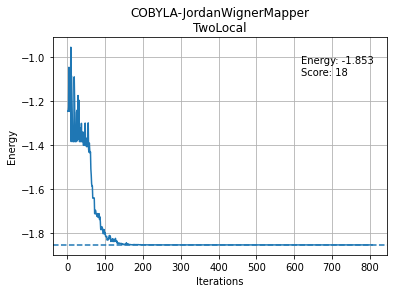

In [11]:
# ディクショナリーに結果を保存します
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# 作った回路をCNOTとUゲートにトランスパイルするUnroller
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuract_thres = 4.0 # mHaの単位
energy = result.optimal_value

if ansatz_type is "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuract_thres,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuract_thres,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# 結果をプロットします
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# データを表示して保存します
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

<div class="alert alert-block alert-danger">
    
<b>練習問題 2</b> 
    
すべてのパラメーターを実験してから：

1. ベストな(最も良いスコアの)経験的なansatz(試行回路)とオプティマイザーを見つけられましたか？(`TwoLocal` ansatzのパラメーターを修正することで)    
2. ベストなq-UCC ansatzとオプティマイザーを見つけられましたか？(`UCCSD, PUCCD, SUCCD` ansatzの中から選択することで)   
3. ansatzを定義するセルで、自分自身でゲートを置くことで`Custom` ansatzを修正して、`TwoLocal`の回路より良い回路を作れましたか？
    
各質問ごとに、`ansatz` オブジェクトを指定します。
化学的精度$|E_{exact} - E_{VQE}| \leq 0.004 $ Ha $= 4$ mHa に到達する必要があることを忘れないでください。

</div>



In [12]:
# このラインの下にコードを書いてください 
#1 
# 単一量子ビット回転は、すべての量子ビットに独立なパラメーターとして置かれます
rotation_blocks = ['ry', 'rz']
# エンタングルさせるゲート
entanglement_blocks = 'cx'
# 量子ビットをどのくらいエンタングルさせるか
#entanglement = 'full' #'full’, ‘linear’ , ‘circular’ or ‘sca’
entanglement_methods = ['full','linear','circular','sca']
# 独立なパラメーターを持った回転ブロックとエンタングルメントのブロックの繰り返し回数
repetitions = 3
# 最後の回転ブロック層をスキップする
skip_final_rotation_layers = [True,False]

best_score = 100000
best_method = None
best_repetitions = 1000
best_skip_final_rotation_layer = None

for entanglemet in entanglement_methods:
    for skip_final_rotation_layer in skip_final_rotation_layers:
        for repetitions in range(1,5):
            ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
            # 初期状態を加える
            ansatz.compose(init_state, front=True, inplace=True)
            counts = []
            values = []
            params = []
            deviation = []

            try:
                initial_point = [0.01] * len(ansatz.ordered_parameters)
            except:
                initial_point = [0.01] * ansatz.num_parameters
            algorithm = VQE(ansatz,optimizer=optimizer,quantum_instance=backend,callback=callback,initial_point=initial_point)
            result = algorithm.compute_minimum_eigenvalue(qubit_op)
            error = abs(result.optimal_value -exact_energy)*1000
            #print(result['error (mHa)'])
            if best_score > error :
                #print("the score update:{}"+format(error))
                best_score = error
                best_method = entanglement
                best_repetitions = repetitions
                best_skip_final_rotation_layer = skip_final_rotation_layer
print(best_score,best_method,best_repetitions,best_skip_final_rotation_layer)
# このラインの上にコードを書いてください 

8.409856366853319e-06 full 3 True


In [13]:
# 2
ansatz_types = ['Custom']
optimizer_types = ['COBYLA','L_BFGS_B','SPSA','SLSQP']
best_score2 = 1000000
best_ansatz = None
best_optimizer = None
for ansatz_type in ansatz_types:
    for optimizer_type in optimizer_types:
        ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
        if ansatz_type == "UCCSD":
            ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
        elif ansatz_type == "PUCCD":
            ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
        elif ansatz_type == "SUCCD":
            ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
        elif ansatz_type == "Custom":    
            # 回路の作り方の例    
            from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister    
            # 変分パラメーターの定義
            theta = Parameter('a')
            n = qubit_op.num_qubits
            # 空の量子回路の作成
            qc = QuantumCircuit(qubit_op.num_qubits)
            qubit_label = 0
            # アダマールゲートを置く
            qc.h([0,2])
            # CNOTを置く
            qc.ry(theta,[0,2])
            qc.cx(0,2)
            # 全量子ビットへrz回転
            qc.rz(theta, range(n))
            ansatz = qc
            ansatz.compose(init_state, front=True, inplace=True)            
            
            
        if optimizer_type == 'COBYLA':
            optimizer = COBYLA(maxiter=1000)
        elif optimizer_type == 'L_BFGS_B':
            optimizer = L_BFGS_B(maxfun=1000)
        elif optimizer_type == 'SPSA':
            optimizer = SPSA(maxiter=500)
        elif optimizer_type == 'SLSQP':
            optimizer = SLSQP(maxiter=1000)
        try:
            initial_point = [0.01] * len(ansatz.ordered_parameters)
        except:
            initial_point = [0.01] * ansatz.num_parameters
        algorithm = VQE(ansatz,
                        optimizer=optimizer,
                        quantum_instance=backend,
                        callback=callback,
                        initial_point=initial_point)
        result = algorithm.compute_minimum_eigenvalue(qubit_op)
        error = abs(result.optimal_value -exact_energy)*1000
        if best_score2 > error :
            best_score2 = error
            best_ansatz = ansatz_type
            best_optimizer = optimizer_type

print(best_score2,best_ansatz,best_optimizer)    
    

553.7279967588975 Custom L_BFGS_B


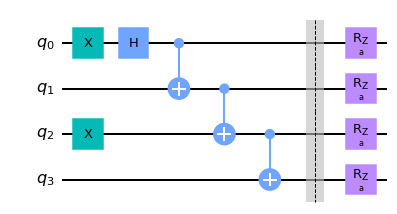

In [14]:
# 3
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister    
# 変分パラメーターの定義
theta = Parameter('a')
n = qubit_op.num_qubits
# 空の量子回路の作成
qc = QuantumCircuit(qubit_op.num_qubits)
qubit_label = 0
# アダマールゲートを置く
qc.h(qubit_label)
# CNOTを置く
for i in range(n-1):
    qc.cx(i, i+1)
# 見た目のためのセパレーター
qc.barrier()
# 全量子ビットへrz回転
qc.rz(theta, range(n))
ansatz = qc
ansatz.compose(init_state, front=True, inplace=True)
ansatz.draw(output='mpl')

***

# パート2: チャレンジ -  LiH分子に対するVQE


このパートでは、PySCFドライバーでSTG-3G基底を用いて、LiH分子をシミュレートします。

</div>
    
<div class="alert alert-block alert-success">
 
<b>目標</b> 
    
すべてのパラメーターを実験して、ベストな試行状態(ansatz)を見つけてください。好きなだけ創造力を発揮してください！

すべての質問において、パート1と同じように`ansatz`オブジェクトを与えてください。最終スコアは、パート2の結果のみで判定されます。
    
</div>

今回はシステムが大きくなったことに注意してください。このシステムに対して量子ビットが何個必要になるか、スピン軌道の数を得ることによって計算します。

   

### 問題サイズの削減

シミュレーション実行時に量子ビット数を減らしたいかもしれません。
- 化学に大きく貢献していないコア電子を凍結し、価電子のみを考慮することができます。Qiskitには、すでにこの機能が実装されています。よって、`qiskit_nature.transformers` において様々なtransformersを調べて、「フローズンコア近似」を実現するものを探してください。
- 2量子ビットを削減するために、`two_qubit_reduction=True`とともに`ParityMapper`を使うことができます。
- ハミルトニアンの対称性を調べることによって量子ビットの数を削減できる可能性があります。Qiskitの`Z2Symmetries`を使う方法を探してみてください。

### 独自の試行状態(ansatz)

[Grimsley *et al.*,2018](https://arxiv.org/abs/1812.11173v2), [H. L. Tang *et al.*,2019](https://arxiv.org/abs/1911.10205), [Rattew *et al.*,2019](https://arxiv.org/abs/1910.09694), [Tang *et al.*,2019](https://arxiv.org/abs/1911.10205)に提案されているアイディアを使ってみたいかもしれません。ベストな試行回路の生成する機械学習アルゴリズムも参考になるかもしれません。

### シミュレーションの設定

次に、ハートリー・フォック計算を実行させ、その後は、あなたにお任せします！

<div class="alert alert-block alert-danger">

<b>注意事項</b> 

`driver`、`initial_point`、`initial_state` は与えられたものを使ってください。
それ以外はQiskitに用意されているものを全て自由に使うことができます。    
つまり、以下の初期点(すべてのパラメーターが0.01に設定されています)から始めてください：  
    
`initial_point = [0.01] * len(ansatz.ordered_parameters)`
    または
`initial_point = [0.01] * ansatz.num_parameters`

また、初期状態はHF状態を使わなければいけません：
    
`init_state = HartreeFock(num_spin_orbitals, num_particles, converter)`
    
質問ごとに、`ansatz`オブジェクトを指定します。
化学的な精度$|E_{exact} - E_{VQE}| \leq 0.004 $ Ha$ = 4$ mHa に到達する必要があることを忘れないでください。
</div>

In [15]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()
vars(qmolecule)

{'_filename': None,
 'origin_driver_name': 'PYSCF',
 'origin_driver_version': '1.7.3',
 'origin_driver_config': 'atom=Li 0.0 0.0 0.0; H 0.0 0.0 1.5474\nunit=Angstrom\ncharge=0\nspin=0\nbasis=sto3g\nhf_method=rhf\nconv_tol=1e-09\nmax_cycle=50\ninit_guess=minao\nmax_memory=None\n',
 'hf_energy': -7.863113882796408,
 'nuclear_repulsion_energy': 1.0259348796432726,
 'num_molecular_orbitals': 6,
 'num_alpha': 2,
 'num_beta': 2,
 'mo_coeff': array([[ 9.91188877e-01, -1.70751821e-01, -2.09344795e-01,
          7.51693344e-18, -5.27480290e-17,  8.64195324e-02],
        [ 3.23740338e-02,  4.50508874e-01,  8.00417768e-01,
         -3.27383813e-17,  2.37018597e-16, -7.23990866e-01],
        [-7.91808351e-20, -1.42765311e-18, -2.23847952e-16,
          1.84750085e-01,  9.82785534e-01,  1.66872869e-16],
        [ 1.29668753e-19, -3.20937146e-17,  6.36968901e-17,
          9.82785534e-01, -1.84750085e-01, -1.13926490e-16],
        [-6.73875146e-03,  3.47864796e-01, -6.12616291e-01,
          2.40421

In [16]:
# このラインの下にコードを書いてください 
num_electrons = qmolecule.num_alpha + qmolecule.num_beta
num_molecular_orbitals = qmolecule.num_molecular_orbitals
num_spin_orbitals = 2 * qmolecule.num_molecular_orbitals
num_qubits = 2* qmolecule.num_molecular_orbitals
energy_nn = qmolecule.nuclear_repulsion_energy
print(num_electrons,num_molecular_orbitals,num_spin_orbitals,num_qubits,energy_nn)
from qiskit_nature.transformers import FreezeCoreTransformer # 追加
from qiskit.aqua.operators import Z2Symmetries # 追加
from qiskit.algorithms import VQE

problem = ElectronicStructureProblem(driver,q_molecule_transformers=[FreezeCoreTransformer(True,[3,4])]) # FreezeCoreTransformerを厳密に指定することがポイント。基底状態で使われないエネルギーが高い軌道をを除外した

# 第二量子化演算子を作ります
second_q_ops = problem.second_q_ops()

# ハミルトニアン
main_op = second_q_ops[0]

# 変換器と量子ビット変換を設定
#mapper_type = 'JordanWignerMapper'
mapper_type = 'ParityMapper'
#mapper_type == 'BravyiKitaevMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True,z2symmetry_reduction=[1]) # z2symmetry_resductionは1つ指定

# フェルミオン演算子が量子ビット演算子に変換されます
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# ansatzを選ぶ
#ansatz_type = "TwoLocal"
#ansatz_type = "UCCSD"
#ansatz_type = "SUCCD"
#ansatz_type = "PUCCD"
ansatz_type = "Custom" # 以下に回路を作成

# q-UCC ansatzのためのパラメーター
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals


optimizer_type = 'COBYLA' 
#optimizer_type == 'L_BFGS_B'
#optimizer_type = 'SPSA'
#optimizer_type == 'SLSQP'
#optimizer_types = ['COBYLA' ]#,'L_BFGS_B','SPSA','SLSQP']

# 各オプティマイザーのパラメーターを調整したいかもしれませんが
# ここではデフォルト値を使います

best_score = 10000
best_ansatz = None
best_result = None
best_optimizer = None
best_ansatz_type = None


if ansatz_type == "TwoLocal":
    # 単一量子ビット回転は、すべての量子ビットに独立なパラメーターとして置かれます
    rotation_blocks = ['ry', 'rz']
    # エンタングルさせるゲート
    entanglement_blocks = 'cz'
    # 量子ビットをどのくらいエンタングルさせるか
    entanglement = 'full' # ['full','linear','circular','sca']
    # 独立なパラメーターを持った回転ブロックとエンタングルメントのブロックの繰り返し回数
    repetitions = 1
    # 最後の回転ブロック層をスキップする
    skip_final_rotation_layer = True #  True/False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # 初期状態を加える
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":    
    # 回路の作り方の例    
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister    
    n = qubit_op.num_qubits
    # 空の量子回路の作成
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # アダマールゲートを置く
    qc.h([0,1])
    for j in range(0,n):
        qc.u3(Parameter('a'+str(j)),Parameter('b'+str(j)),Parameter('c'+str(j)),j)
    count = 0
    for _ in range(1):
        for i in range(0,n-1):
            qc.cx(i,i+1) # CNOTを置き全量子ビットに線形に量子もつれ状態を生成
            qc.u3(Parameter('x'+str(count)),Parameter('y'+str(count)),Parameter('w'+str(count)),i+1) # 次の量子ビットと相互作用する前に状態を調整
            count += 1
    for j in range(n):
        qc.u3(Parameter('m'+str(j)),Parameter('n'+str(j)),Parameter('o'+str(j)),j)
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)



if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=20000) # 収束にイテレーション数がかかるので、こちらを調整。
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=20000)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=20000)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=20000)


counts = []
values = []
params = []
deviation = []

# ansatzの初期パラメーターを設定します
# すべての参加者が似たような初期ポイントから始められるように
# 固定の小さい変位を選びます
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)#,
                #include_custom=True)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)
# このラインの上にコードを書いてください 

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 9704,
    'eigenstate': array([-3.06635074e-03-9.93197986e-04j, -1.64680883e-03-4.56929361e-03j,
        1.50109890e-02+2.25000381e-02j, -5.34832542e-01-8.34667524e-01j,
       -2.85353037e-02-4.62670074e-02j, -1.11008764e-04-2.60459308e-04j,
        4.64714740e-04+8.24714008e-04j, -9.76999121e-03-2.34713692e-02j,
       -1.99921505e-03-2.11244742e-03j, -5.12862763e-06-4.26643298e-06j,
        3.28442008e-06-1.29897928e-06j,  3.07851565e-04+3.42419161e-04j,
        6.13864065e-02+9.55963775e-02j,  1.96650628e-04+2.84339645e-04j,
       -4.14132696e-04-3.83390214e-04j,  6.15759741e-04-1.86453970e-04j]),
    'eigenvalue': -1.08637338419543,
    'optimal_parameters': {   Parameter(x2): 0.6843293413730569,
                              Parameter(y2): 0.32757379153681954,
                              Parameter(w2): -0.3902842431870434,
                              Parameter(m0): 0.15053417727937582,
                         

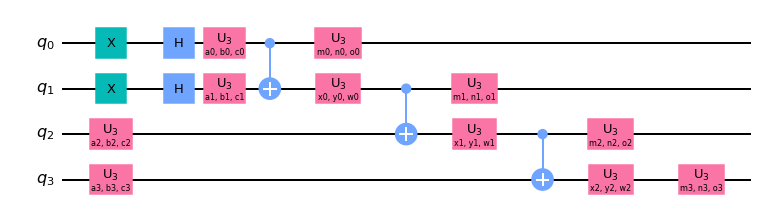

In [17]:
ansatz.draw(output='mpl')

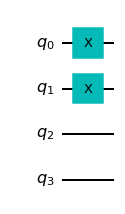

In [18]:
init_state.draw(output='mpl')

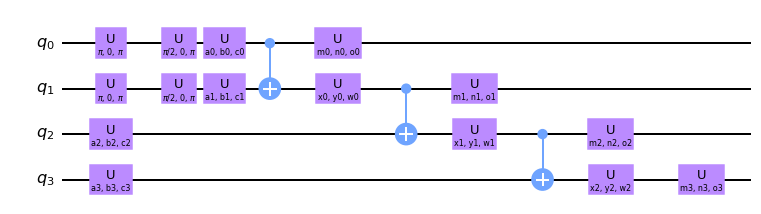

In [19]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# 作った回路をCNOTとUゲートにトランスパイルするUnroller
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
ansatz_tp.draw(output='mpl')

In [20]:
# 以下のコードで答えを確認してください。
from qc_grader import grade_ex5
freeze_core = True # 核電子を凍結した場合はTrueにします。
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.



In [ ]:
# 答えを提出します。何度でも再提出できます。
from qc_grader import submit_ex5
freeze_core = True # 核電子を凍結した場合はTrueにします。
submit_ex5(ansatz,qubit_op,result,freeze_core)

# パート1の質問の解答

<div class="alert alert-block alert-danger">
    
<b> 練習問題 1</b> 
    
`qmolecule`の特性を調べて、以下の質問に答えましょう。
    
1. 分子の基本的特性を知る必要があります。与えられた系の電子は合計何個ですか？
2. 分子軌道は何個あります？    
3. スピン軌道は何個あります？  
4. この分子をシミュレートするためにジョルダン・ウィグナー変換では何量子ビット必要ですか？
5. 核反発エネルギーの値はいくつですか？

    
</div>

<div class="alert alert-block alert-success">

<b>解答 </b> 

1. `n_el = qmolecule.num_alpha + qmolecule.num_beta`
    
2. `n_mo = qmolecule.num_molecular_orbitals`
    
3. `n_so = 2 * qmolecule.num_molecular_orbitals`
    
4. `n_q = 2* qmolecule.num_molecular_orbitals`
    
5. `e_nn = qmolecule.nuclear_repulsion_energy`
    
    
</div>

## Additional information

**Created by:** Igor Sokolov, Junye Huang, Rahul Pratap Singh

**Version:** 1.0.0